In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [4]:
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'


In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(244, 244),
    batch_size=64,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(244, 244),
    batch_size=64,
    class_mode='binary',
    subset='validation'
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(244, 244),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [28]:
model = models.Sequential([
    layers.Conv2D(64, (3, 3), padding='same', activation=None, input_shape=(244, 244, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),

    layers.Conv2D(128, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),

    layers.Conv2D(128, (3, 3), padding='same', activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(128, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])


In [29]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'] )


In [30]:
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 244, 244, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 244, 244, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 244, 244, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 122, 122, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 122, 122, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 122, 122, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 122, 122, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 122, 122, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 61, 61, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 61, 61, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 61, 61, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 61, 61, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_23 (Activation)      │ (None, 61, 61, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_24 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,970,881 (57.11 MB)

 Trainable params: 14,969,985 (57.11 MB)

 Non-trainable params: 896 (3.50 KB)

"I used test data instead of validation data because the number of validation samples is only 16, which is very small, and as a result, the model achieves low accuracy. Therefore, I used test data as validation data to improve the model's performance."

In [31]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15
)

Epoch 1/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8762 - loss: 0.3154 - val_accuracy: 0.7430 - val_loss: 1.5565
Epoch 2/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 856ms/step - accuracy: 0.9724 - loss: 0.0889 - val_accuracy: 0.7430 - val_loss: 2.1844
Epoch 3/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 856ms/step - accuracy: 0.9740 - loss: 0.0710 - val_accuracy: 0.7430 - val_loss: 2.3901
Epoch 4/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 858ms/step - accuracy: 0.9784 - loss: 0.0535 - val_accuracy: 0.7430 - val_loss: 2.7451
Epoch 5/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 853ms/step - accuracy: 0.9889 - loss: 0.0400 - val_accuracy: 0.7430 - val_loss: 2.9877
Epoch 6/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 851ms/step - accuracy: 0.9886 - loss: 0.0335 - val_accuracy: 0.7430 - val_loss: 2.8567
Epoch 7/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 859ms/step - accuracy: 0.9896 - loss: 0.0300 - val_accuracy: 0.7430 - val_loss: 2.9421
Epoch 8/15
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 841ms/step - accuracy: 0.9923 - loss: 0.0267 - val_accurac

In [32]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {test_acc:.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 653ms/step - accuracy: 0.3325 - loss: 5.9073

✅ Test Accuracy: 0.63


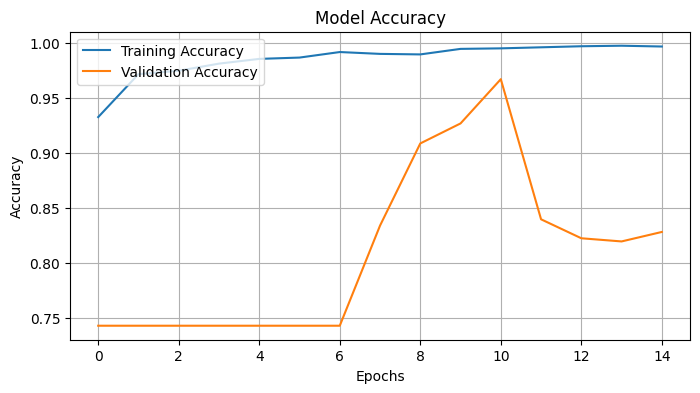

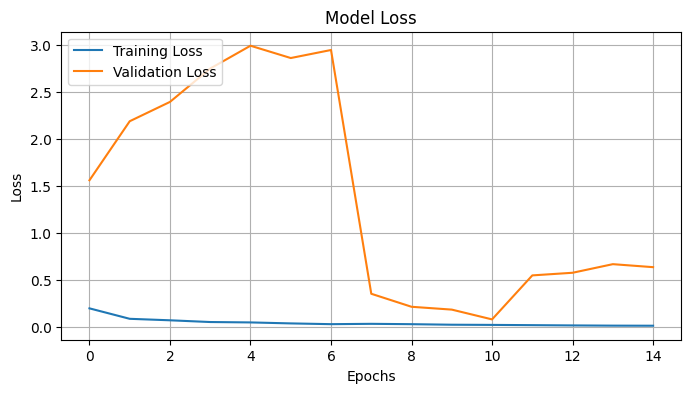

In [33]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
label = PNEUMONIA


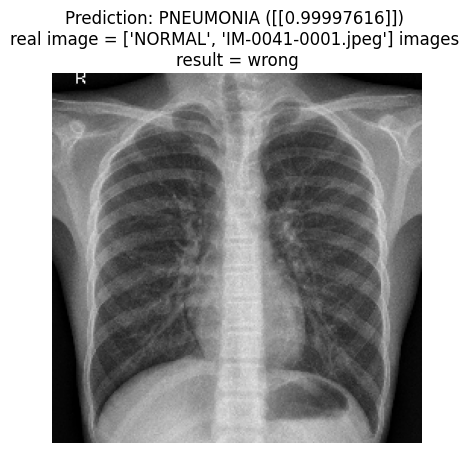

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
label = PNEUMONIA


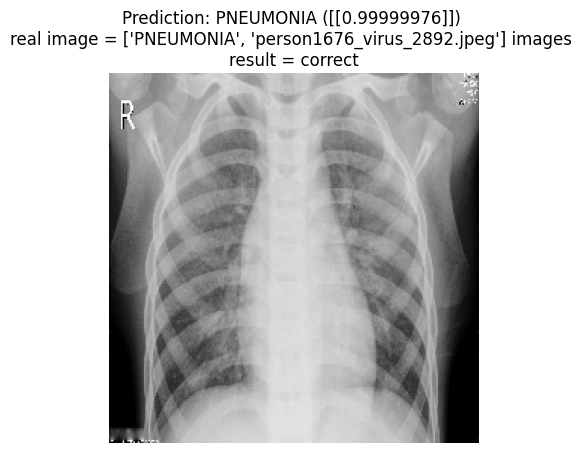

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
label = PNEUMONIA


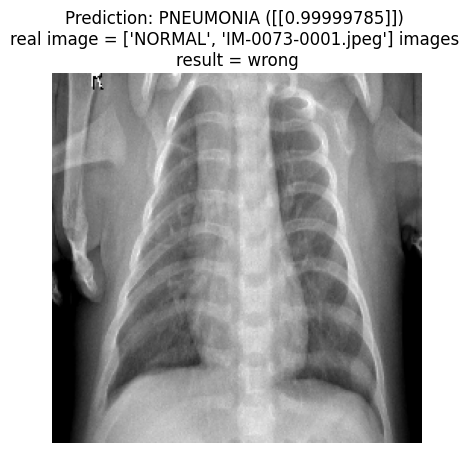

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
label = PNEUMONIA


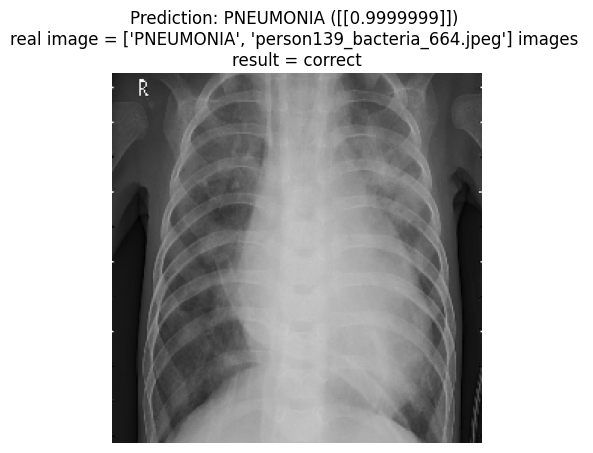

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
label = PNEUMONIA


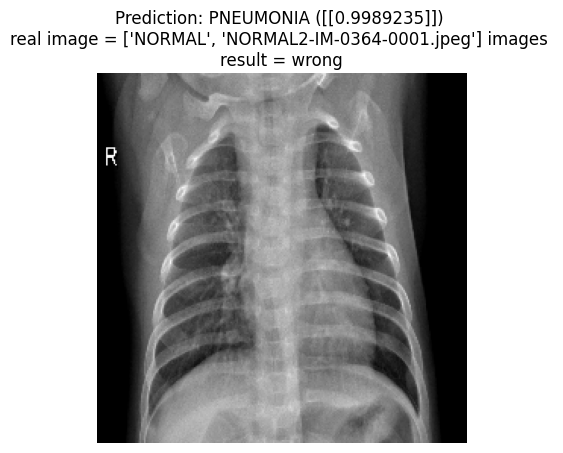

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
label = PNEUMONIA


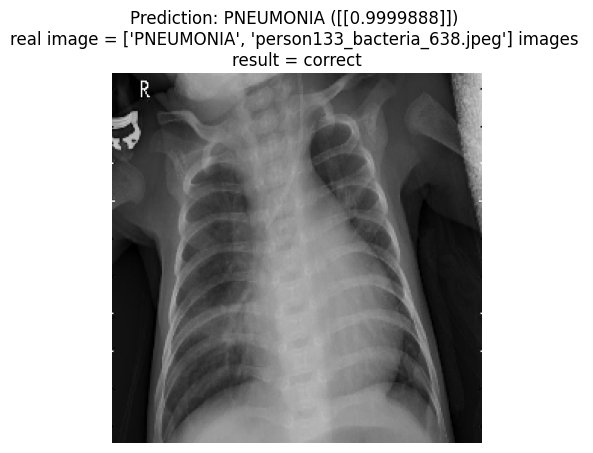

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
label = PNEUMONIA


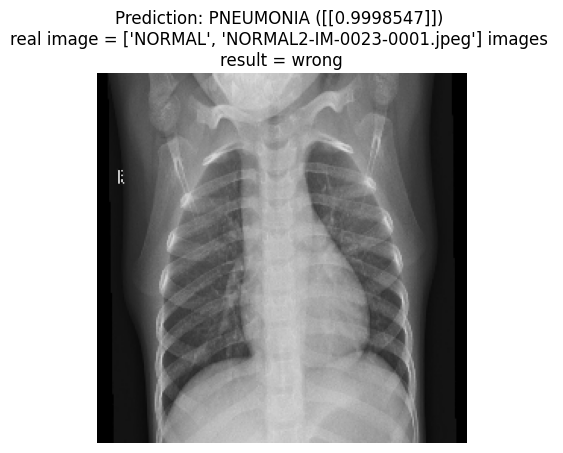

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
label = PNEUMONIA


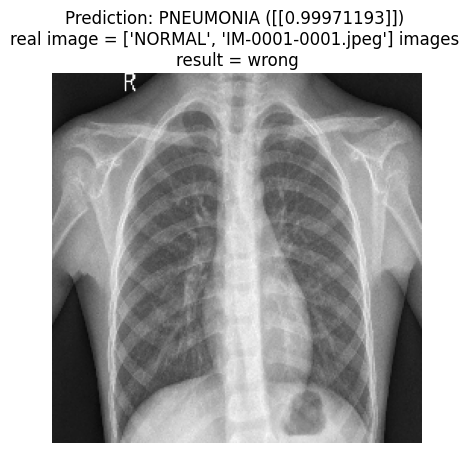

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
label = PNEUMONIA


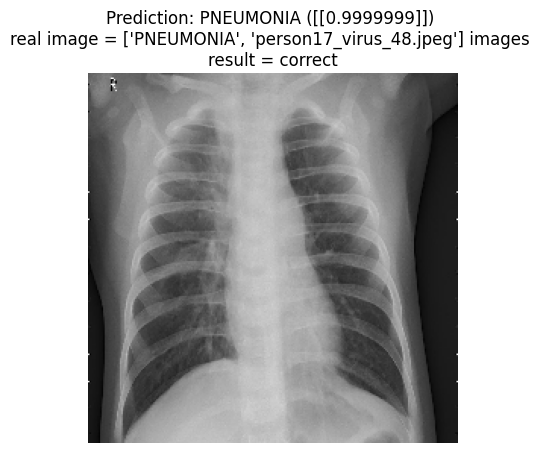

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
label = PNEUMONIA


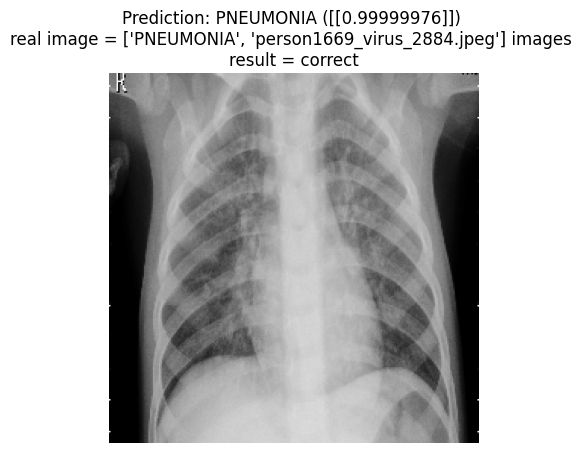

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
label = PNEUMONIA


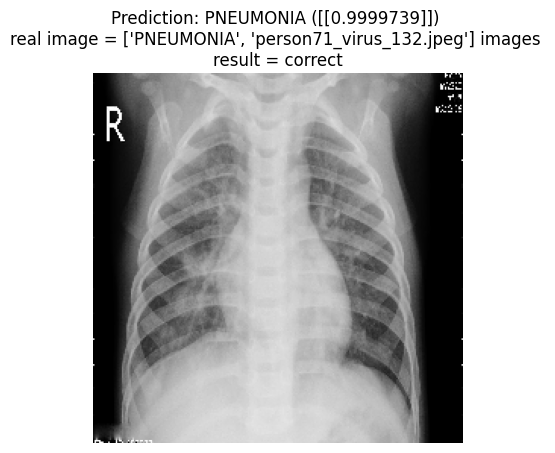

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
label = PNEUMONIA


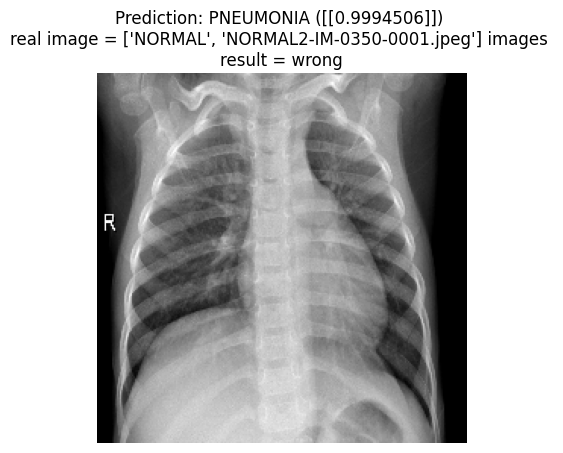

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
label = PNEUMONIA


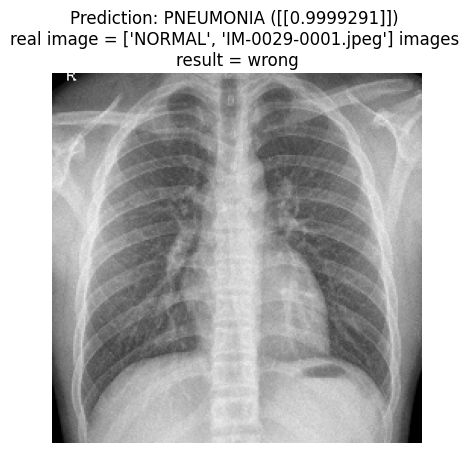

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
label = PNEUMONIA


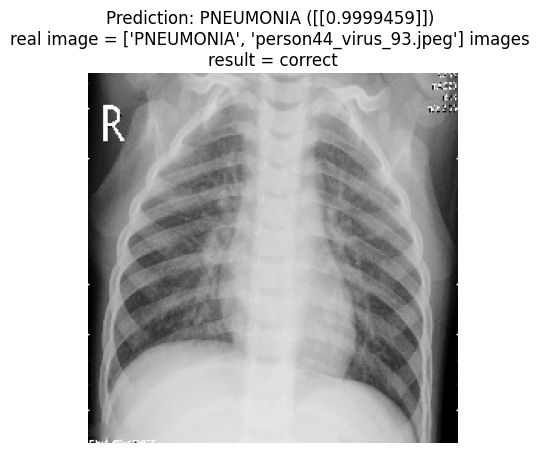

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
label = PNEUMONIA


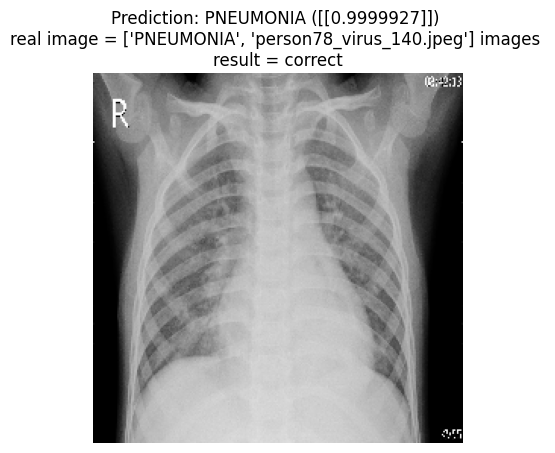

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
label = PNEUMONIA


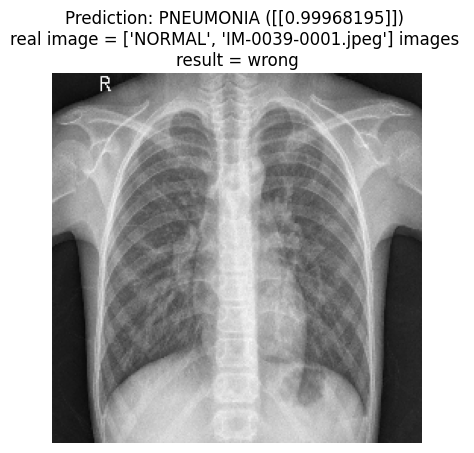

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
label = PNEUMONIA


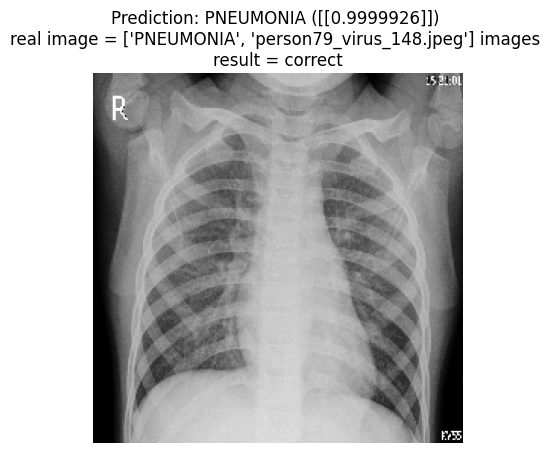

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
label = PNEUMONIA


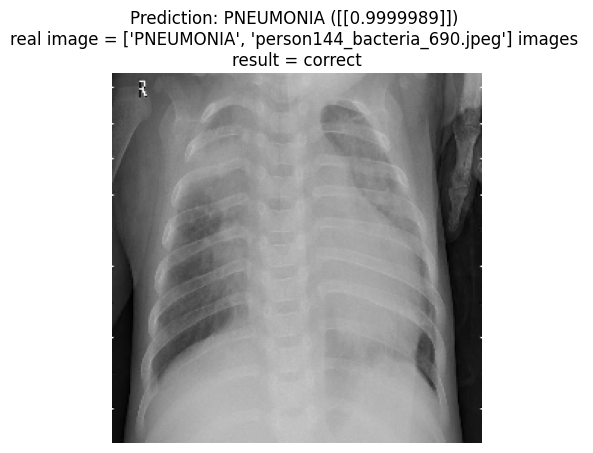

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
label = PNEUMONIA


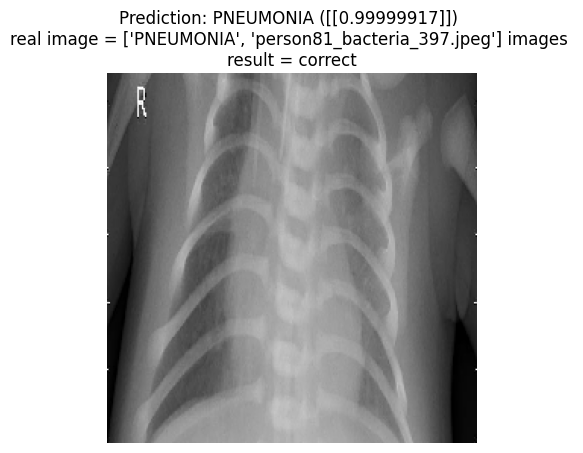

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
label = PNEUMONIA


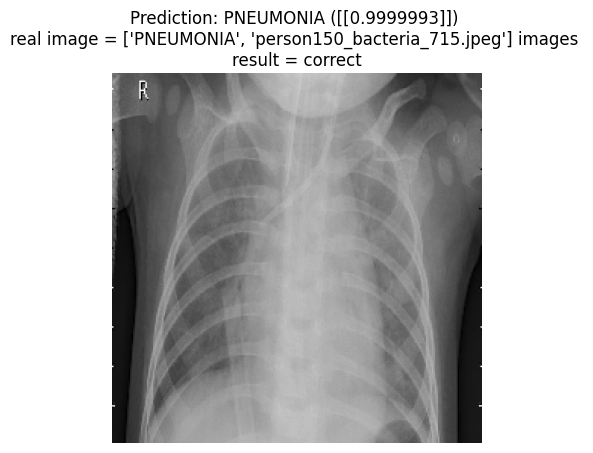

In [34]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

NORMAL_images = os.path.join(test_dir, "NORMAL")
PNEUMONIA_images = os.path.join(test_dir, "PNEUMONIA")
category = [NORMAL_images , PNEUMONIA_images]
test_size = 20

for i in range(test_size):
    random_catg = random.choice(category)

    test_image = os.path.join(random_catg, random.choice(os.listdir(random_catg)))
    img = image.load_img(test_image, target_size=(244, 244))

    img_array= image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)

    label = "PNEUMONIA" if prediction[0] > 0.5 else "NORMAL"
    print(f"label = {label}")
    if label in str(random_catg):
        predict_result = "correct"
    else:
        predict_result = "wrong"

    plt.imshow(img)
    plt.title(f"Prediction: {label} ({prediction}) \nreal image = {test_image.split('/')[-2:]} images \nresult = {predict_result}")
    plt.axis('off')
    plt.show()

